## Face Recognition

In this tutorial, we are going to use the pre-trained VGG-Face network [1] to recognize faces of celebrities. The VGG-Face is a deep-CNN which has been trained using Softmax loss to recognize faces of 2,622 celebrity identities. We will use face images (that have been downloaded from the internet) of a random subset of 10  celebrities, out of the 2,622.

In [3]:
import math
import cv2
import numpy as np

import torch
from torch.utils.serialization import load_lua
from torch.legacy import nn

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline 
plt.ion()

In [4]:
def getNameList(filePath):
    names = []
    with open(filePath) as f:
        names = [ line.strip() for line in f ]
    return names

idNames = getNameList("../../data/lab3/names.txt")
print "Number of identities = ", len(idNames)
print "List of the first 5 identities = ", idNames[:5]

Number of identities =  2622
List of the first 5 identities =  ['A.J._Buckley', 'A.R._Rahman', 'Aamir_Khan', 'Aaron_Staton', 'Aaron_Tveit']


Now, let us take a quick look at some of the face images in our dataset. For the convenience of the participants, we have packaged the image names of all the 10 face images in the form of a .t7 data file that can be loaded onto our PyTorch scripts.

In [5]:
dataset = load_lua("../../data/lab3/Experiment_1/facerec-image-dataset.t7")
print "No. of images = ", len(dataset['images'])
for imgName in dataset['images']:
    print imgName

No. of images =  10
Aamir_Khan.png
Amy_Schumer.jpg
Anne_Hathaway.jpg
A_P_J_Abdul_Kalam.jpg
A.R._Rahman.jpg
Julia_Roberts.jpg
Kangana_Ranaut.jpg
Kit_Harington.jpg
Louis_CK.jpg
Madhuri_Dixit.jpg


Let us take the first image in our dataset and visualize what it looks like. Feel free to modify the code if you wish to look at more face images from the dataset!

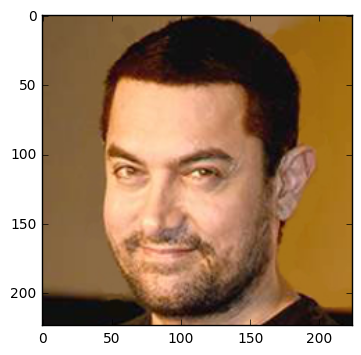

In [6]:
dispImg = mpimg.imread("../../data/lab3/Experiment_1/" + dataset['images'][0])
imgplot = plt.imshow(dispImg)

Before sending the images through the network, we have to perform certain pre-processing steps to make our input image "suitable" for the network. Each CNN has a fixed size of input images that it can accept. The VGG-Face netowrk architecture has been trained on 224 $\times$ 224 RGB images. Therefore, any image that we send as an input must be of 224 $\times$ 224 size.

So, can we simply perform a resize operation on our input image and convert it to the appropriate size? Performing a simple resize operation on arbitrary sized input images may result in a change in the aspect ratio, thereby making the face image look distorted. To avoid that, we perform the following sequence of operations -- 

1. Resize the image such that the smaller dimension (out of height and width) is 256 and the aspect ratio remains the same.
2. Crop a 224 $\times$ 224 region from the center of the resized image.

We will perform the above steps using OpenCV.

In [7]:
# load the image using OpenCV
inputImg = cv2.imread("../../data/lab3/Experiment_1/" + dataset['images'][0])

# re-scale the smaller dim (among width, height) to refSize
refSize, targetSize = 256, 224
imgRows, imgCols = inputImg.shape[0], inputImg.shape[1]
if imgCols < imgRows: resizedImg = cv2.resize(inputImg, (refSize, refSize * imgRows / imgCols))
else: resizedImg = cv2.resize(inputImg, (refSize * imgCols / imgRows, refSize))
    
# center-crop
oH, oW = targetSize, targetSize
iH, iW = resizedImg.shape[0], resizedImg.shape[1]
anchorH, anchorW = int(math.ceil((iH - oH)/2)), int(math.ceil((iW - oW) / 2))
croppedImg = resizedImg[anchorH:anchorH+oH, anchorW:anchorW+oW]

print croppedImg.shape

(224, 224, 3)


As you can see, we have resized and cropped our input image to the correct dimensions.

Moving on, the VGG-Face network expects the shape of the input image to be $3 \times 224 \times 224$, which means that the 1st dimension corresponds to the image channel. On the other hand, what we have is an input image whose shape is $224 \times 224 \times 3$ where the last dimension is for the channel. Therefore, in order to make the shapes of the input Tensors consistent, we perform the necessary conversion.

In [8]:
# convert shape from (height, width, 3) to (3, width, height)
channel_1, channel_2, channel_3 = croppedImg[:, :, 0], croppedImg[:, :, 1], croppedImg[:, :, 2]
croppedImg = np.empty([3, croppedImg.shape[0], croppedImg.shape[1]])
croppedImg[0], croppedImg[1], croppedImg[2] = channel_1, channel_2, channel_3

print croppedImg.shape

(3, 224, 224)


As a final step, we perform mean subtraction. You might be aware that the input data that is used for training deep CNNs is mean subtracted (this is critical for the stabiliity of the training process). Similarly, while training the VGG-Face network, the per-channel mean of the training images was computed and the same mean value now has to be subtracted for any face image that is used to test the network.

In [9]:
# subtract training mean
inputImg = inputImg.astype(float)
trainingMean = [129.1863, 104.7624, 93.5940]
for i in range(3): croppedImg[i] = croppedImg[i] - trainingMean[i]

Before we proceed, a quick recap. We have pre-processed our input face images by performing the following steps:
1. Resize (to a slightly bigger size) while maintaining aspect ratio
2. Crop a face patch from the center of the required dimensions
3. Convert to an appropriate shape
4. Subtract the training mean

Moving forward, let us load the pre-trained network and see it's structure.

In [10]:
# load pre-trained VGG-Face network
vggFace = load_lua("../../data/lab3/VGG_FACE_pyTorch_small.t7")
vggFace.modules[31] = nn.View(1, 25088)
vggFace = vggFace.cuda()
print vggFace


nn.Sequential {
  [input -> (0) -> (1) -> (2) -> (3) -> (4) -> (5) -> (6) -> (7) -> (8) -> (9) -> (10) -> (11) -> (12) -> (13) -> (14) -> (15) -> (16) -> (17) -> (18) -> (19) -> (20) -> (21) -> (22) -> (23) -> (24) -> (25) -> (26) -> (27) -> (28) -> (29) -> (30) -> (31) -> (32) -> (33) -> (34) -> (35) -> (36) -> (37) -> (38) -> (39) -> output]
  (0): nn.SpatialConvolution(3 -> 64, 3x3, 1, 1, 1, 1)
  (1): nn.ReLU
  (2): nn.SpatialConvolution(64 -> 64, 3x3, 1, 1, 1, 1)
  (3): nn.ReLU
  (4): nn.SpatialMaxPooling(2x2, 2, 2)
  (5): nn.SpatialConvolution(64 -> 128, 3x3, 1, 1, 1, 1)
  (6): nn.ReLU
  (7): nn.SpatialConvolution(128 -> 128, 3x3, 1, 1, 1, 1)
  (8): nn.ReLU
  (9): nn.SpatialMaxPooling(2x2, 2, 2)
  (10): nn.SpatialConvolution(128 -> 256, 3x3, 1, 1, 1, 1)
  (11): nn.ReLU
  (12): nn.SpatialConvolution(256 -> 256, 3x3, 1, 1, 1, 1)
  (13): nn.ReLU
  (14): nn.SpatialConvolution(256 -> 256, 3x3, 1, 1, 1, 1)
  (15): nn.ReLU
  (16): nn.SpatialMaxPooling(2x2, 2, 2)
  (17): nn.SpatialConvolu

As you can see, there are 40 layers in total. The architecture can be divided into 5 Convolutional blocks followed by 2 fc layers and a classification layer. Each convolutional block consists of multiple Conv+ReLU layers followed by a pooling layer.

Let us now send our pre-processed input image through the network i.e. we are going to do a forward pass through the pre-trained VGG-Face network.

In [11]:
# forward pass
input = torch.Tensor(croppedImg).unsqueeze(0)
output = vggFace.forward(input.cuda())
output = output.cpu().numpy()

print output.shape

(1, 2622)


The network has returned a single row of 2,622 entries. These values are the normalized log probabilities of our input face image belonging to each of the 2,622 celebrity IDs in the training set. So, in order to know which ID is the most likely (as per the network), we figure out the one which has the maximum probability.

To get the name of the ID from the index, we use the list of ID names that we had loaded at the start of the tutorial. As you can guess, the order of names in the list is important and serves as a mapping between the index number and the name.

In [12]:
print "ID = ", idNames[np.argmax(output)]

ID =  Aamir_Khan


What are the top-k predictions made by the network for our input image?

In [13]:
# top-k predictions
ind = output[0].argsort()[-5:][::-1]
for idx in ind:
    print idNames[idx]

Aamir_Khan
Manish_Dayal
Adam_Driver
John_Abraham
Adam_Copeland


We have seen how to use the pre-trained net to make predictions (face recognition). The VGG-Face net can also be used as a fixed feature extractor for face images. We simply ignore the outputs of the classification layer and take the output of the last fc-layer instead.

In [15]:
vggFeatures = vggFace.modules[35].output.cpu().numpy()
print vggFeatures.shape
print vggFeatures

(1, 4096)
[[ 0.  0.  0. ...,  0.  0.  0.]]


It seems like most (all?) of the entries in the face descriptor are 0! How can we confirm/deny this fact? Let's try and check what the $\ell-2$ norm of the descriptor is.

In [16]:
print np.linalg.norm(vggFeatures)

131.948


This confirms the fact that the entries in the descriptor are not all zero!

The 4096-d face features that we obtain in this fashion can used for a variety of face-related tasks, as we will see in the subsequent tutorials.